In [1]:
%load_ext autoreload
%autoreload 2

# Добавляем путь к основной папке проекта, чтобы иметь возможность делать импорт из src
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import catboost

In [3]:
data = pd.read_csv('../data/classification_dataset.csv')
print(data.shape)
data.head()

(404886, 17)


,tx_hash,current_block,timestamp,status,availablePriorityFee,gas,already_waiting,baseFeePerGas,previousBlockGasUsed,is_ofac,included,priority_n,total_eligible_txs,priority_percent,cumulative_gas,first_gas_unit,last_gas_unit
0,0x36a8f87e6be412d5d3ef5c774e221e610b5c8871463b...,16221292,1671483623,ok,1092.697098,175920,1.0,18.302902,22334900,False,next_block,0,346,0.000000,175920,0.000000,0.005864
1,0x1be4691644fd620612a44c306341d3e4e5c4486ada4e...,16221292,1671483623,ok,686.697098,175920,4.0,18.302902,22334900,False,now,1,346,0.002890,351840,0.005864,0.011728
2,0xe67a86403cbe1dd893b764c49bdc86d821fcbd81d996...,16221292,1671483623,ok,599.000000,175920,2.0,18.302902,22334900,False,next_block,2,346,0.005780,527760,0.011728,0.017592
3,0x98afadc301f16fb299311247444e77a422dbf35deddf...,16221292,1671483623,ok,511.000000,175920,5.0,18.302902,22334900,False,now,3,346,0.008671,703680,0.017592,0.023456
4,0x9ec221ab70707257d9343329a607667624423144b046...,16221292,1671483623,ok,444.000000,175920,2.0,18.302902,22334900,False,next_block,4,346,0.011561,879600,0.023456,0.029320


In [12]:
# Всего блоков в датасете

data['current_block'].nunique()

1937

In [13]:
# Последние 350 блоков из 

valid_blocks = sorted(data['current_block'].unique())[-350:]

In [133]:
# Выставим target

data['target'] = 0
data.loc[data['included'] == 'now', 'target'] = 1

In [149]:
data['target'].value_counts()

1    298179
0    106707
Name: target, dtype: int64

In [150]:
from catboost import CatBoostClassifier

In [151]:
feature_columns = ['availablePriorityFee', 'gas', 'already_waiting', 'baseFeePerGas',
                   'previousBlockGasUsed', 'priority_n',
                   'total_eligible_txs', 'priority_percent', 'cumulative_gas',
                   'first_gas_unit', 'last_gas_unit']

In [198]:
data_non_ofac = data[~data['is_ofac']].copy()
data_ofac = data[data['is_ofac']].copy()

In [153]:
train_data = data_non_ofac[~data_non_ofac['current_block'].isin(valid_blocks)].copy()
valid_data = data_non_ofac[data_non_ofac['current_block'].isin(valid_blocks)].copy()

In [154]:
X_train = train_data[feature_columns].copy()
y_train = train_data['target'].copy()

X_valid = valid_data[feature_columns].copy()
y_valid = valid_data['target'].copy()

In [175]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_valid), y=y_valid)
class_weights

array([1.39239788, 0.7801441 ])

In [176]:
model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.01,
    class_weights=class_weights
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    # cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=100
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 0.6815031	test: 0.6781669	best: 0.6781669 (0)	total: 14ms	remaining: 21s
100:	learn: 0.3102485	test: 0.2465799	best: 0.2465799 (100)	total: 1.09s	remaining: 15.1s
200:	learn: 0.2688775	test: 0.2058475	best: 0.2058475 (200)	total: 2.12s	remaining: 13.7s
300:	learn: 0.2546151	test: 0.2004653	best: 0.2004565 (299)	total: 3.14s	remaining: 12.5s
400:	learn: 0.2457109	test: 0.1985966	best: 0.1985966 (400)	total: 4.18s	remaining: 11.4s
500:	learn: 0.2383618	test: 0.1979909	best: 0.1979896 (491)	total: 5.2s	remaining: 10.4s
600:	learn: 0.2320715	test: 0.1976086	best: 0.1975531 (579)	total: 6.24s	remaining: 9.34s
700:	learn: 0.2261642	test: 0.1973109	best: 0.1971908 (676)	total: 7.27s	remaining: 8.29s
800:	learn: 0.2209848	test: 0.1970378	best: 0.1970347 (766)	total: 8.32s	remaining: 7.26s
900:	learn: 0.2162661	test: 0.1967417	best: 0.1966131 (853)	total: 9.36s	remaining: 6.22s
1000:	learn: 0.2119148	test: 0.1967938	best: 0.1966131 (853)	total: 10.4s	remaining: 5.18s
1100:	learn: 0.20

In [177]:
pred = model.predict(X_valid)

In [195]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [197]:
print(f'Precision {precision_score(y_valid, pred):0.3f}')
print(f'Recall {recall_score(y_valid, pred):0.3f}')
print(f'F1 {f1_score(y_valid, pred):0.3f}')

Precision 0.935
Recall 0.981
F1 0.957


In [202]:
ofac_feats = data_ofac[feature_columns].copy()
ofac_target = data_ofac['target'].copy()
ofac_pred = model.predict(ofac_feats)

print(f'Precision {precision_score(ofac_target, ofac_pred):0.3f}')
print(f'Recall {recall_score(ofac_target, ofac_pred):0.3f}')
print(f'F1 {f1_score(ofac_target, ofac_pred):0.3f}')

Precision 0.470
Recall 0.965
F1 0.633


In [203]:
feature_imp = sorted(zip(feature_columns, model.get_feature_importance()), key=lambda x:x[1], reverse=True)

for col, imp in feature_imp:
    print(f'{col} - {imp:0.5f}')

already_waiting - 69.06679
total_eligible_txs - 7.36019
baseFeePerGas - 6.20552
previousBlockGasUsed - 6.06498
availablePriorityFee - 4.30636
cumulative_gas - 1.78796
last_gas_unit - 1.54329
first_gas_unit - 1.11912
priority_n - 1.10769
priority_percent - 0.74592
gas - 0.69218


In [204]:
pred_proba = model.predict_proba(X_valid)

In [205]:
from sklearn.calibration import calibration_curve

In [206]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_valid, pred_proba[:, 1], n_bins=20)

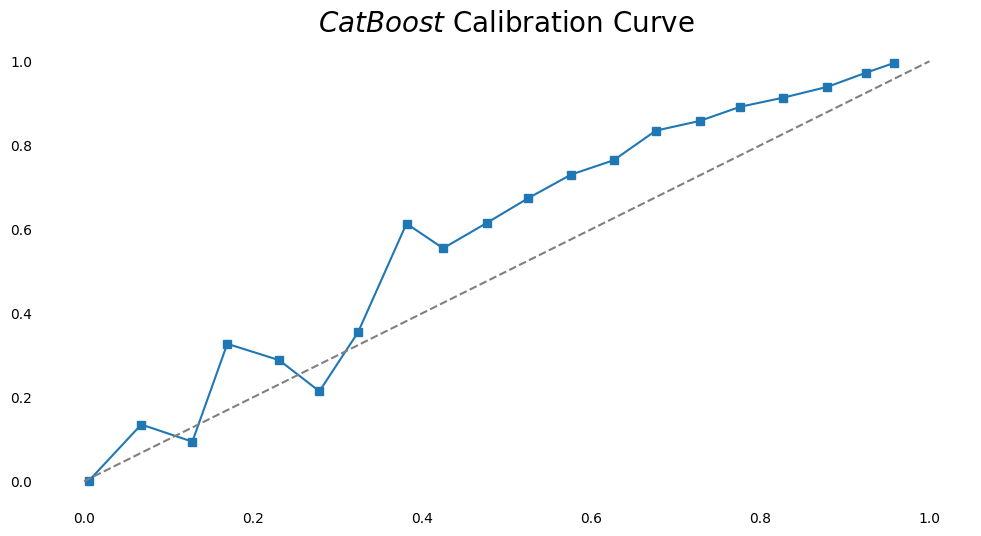

In [207]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$CatBoost$ Calibration Curve", fontsize=20); pass

In [214]:
from sklearn.calibration import CalibratedClassifierCV

clf_sigmoid = CalibratedClassifierCV(CatBoostClassifier(iterations=1500,
                                                        learning_rate=0.01,
                                                        class_weights=class_weights),
                                     cv=5, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)

0:	learn: 0.6809740	total: 9.95ms	remaining: 14.9s
1:	learn: 0.6692987	total: 20.6ms	remaining: 15.4s
2:	learn: 0.6574413	total: 29ms	remaining: 14.5s
3:	learn: 0.6466210	total: 37.8ms	remaining: 14.1s
4:	learn: 0.6355854	total: 46ms	remaining: 13.8s
5:	learn: 0.6253921	total: 54.1ms	remaining: 13.5s
6:	learn: 0.6159502	total: 62.4ms	remaining: 13.3s
7:	learn: 0.6070484	total: 70ms	remaining: 13.1s
8:	learn: 0.5974562	total: 78.5ms	remaining: 13s
9:	learn: 0.5883674	total: 86.4ms	remaining: 12.9s
10:	learn: 0.5794627	total: 95.7ms	remaining: 13s
11:	learn: 0.5710485	total: 105ms	remaining: 13.1s
12:	learn: 0.5624956	total: 113ms	remaining: 13s
13:	learn: 0.5548472	total: 122ms	remaining: 12.9s
14:	learn: 0.5465933	total: 130ms	remaining: 12.9s
15:	learn: 0.5397113	total: 138ms	remaining: 12.8s
16:	learn: 0.5329936	total: 146ms	remaining: 12.7s
17:	learn: 0.5262411	total: 155ms	remaining: 12.7s
18:	learn: 0.5193126	total: 163ms	remaining: 12.7s
19:	learn: 0.5120936	total: 171ms	remainin

CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x7f47e88a42b0>)

In [216]:
clf_isotonic = CalibratedClassifierCV(CatBoostClassifier(iterations=1500,
                                                        learning_rate=0.01,
                                                        class_weights=class_weights),
                                     cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train)

0:	learn: 0.6809740	total: 12.4ms	remaining: 18.6s
1:	learn: 0.6692987	total: 22.2ms	remaining: 16.6s
2:	learn: 0.6574413	total: 30.2ms	remaining: 15.1s
3:	learn: 0.6466210	total: 38.2ms	remaining: 14.3s
4:	learn: 0.6355854	total: 46ms	remaining: 13.7s
5:	learn: 0.6253921	total: 53.6ms	remaining: 13.4s
6:	learn: 0.6159502	total: 61.4ms	remaining: 13.1s
7:	learn: 0.6070484	total: 69.6ms	remaining: 13s
8:	learn: 0.5974562	total: 80ms	remaining: 13.2s
9:	learn: 0.5883674	total: 87.7ms	remaining: 13.1s
10:	learn: 0.5794627	total: 95.6ms	remaining: 12.9s
11:	learn: 0.5710485	total: 103ms	remaining: 12.8s
12:	learn: 0.5624956	total: 111ms	remaining: 12.7s
13:	learn: 0.5548472	total: 121ms	remaining: 12.8s
14:	learn: 0.5465933	total: 129ms	remaining: 12.8s
15:	learn: 0.5397113	total: 138ms	remaining: 12.8s
16:	learn: 0.5329936	total: 146ms	remaining: 12.7s
17:	learn: 0.5262411	total: 154ms	remaining: 12.7s
18:	learn: 0.5193126	total: 162ms	remaining: 12.6s
19:	learn: 0.5120936	total: 170ms	re

CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x7f47e861faf0>,
                       method='isotonic')

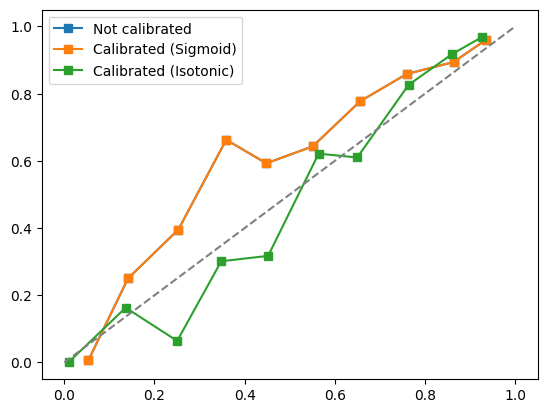

In [224]:
y_valid_predict_proba_sigmoid = clf_sigmoid.predict_proba(X_valid)[:, 1]
fraction_of_positives_sigmoid, mean_predicted_value_sigmoid = calibration_curve(y_valid, y_valid_predict_proba_sigmoid, n_bins=10)

y_valid_predict_proba_isotonic = clf_isotonic.predict_proba(X_valid)[:, 1]
fraction_of_positives_isotonic, mean_predicted_value_isotonic = calibration_curve(y_valid, y_valid_predict_proba_isotonic, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Not calibrated')
plt.plot(mean_predicted_value_sigmoid, fraction_of_positives_sigmoid, 's-', label='Calibrated (Sigmoid)')
plt.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, 's-', label='Calibrated (Isotonic)')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend()

In [225]:
# Base model

print(f'Precision {precision_score(y_valid, pred):0.3f}')
print(f'Recall {recall_score(y_valid, pred):0.3f}')
print(f'F1 {f1_score(y_valid, pred):0.3f}')

Precision 0.935
Recall 0.981
F1 0.957


In [226]:
# Sigmoid calibrated
pred_sigmoid = clf_sigmoid.predict(X_valid)

print(f'Precision {precision_score(y_valid, pred_sigmoid):0.3f}')
print(f'Recall {recall_score(y_valid, pred_sigmoid):0.3f}')
print(f'F1 {f1_score(y_valid, pred_sigmoid):0.3f}')

Precision 0.934
Recall 0.979
F1 0.956


In [227]:
# Isotonic calibrated
pred_isotonic = clf_isotonic.predict(X_valid)

print(f'Precision {precision_score(y_valid, pred_isotonic):0.3f}')
print(f'Recall {recall_score(y_valid, pred_isotonic):0.3f}')
print(f'F1 {f1_score(y_valid, pred_isotonic):0.3f}')

Precision 0.927
Recall 0.993
F1 0.959
